**Training and Testing Data**


This facial keypoints dataset consists of 5770 color images. All of these images are separated into either a training or a test set of data.

* 3462 of these images are training images, for you to use as you create a model to predict keypoints.
* 2308 are test images, which will be used to test the accuracy of your model.

The information about the images and keypoints in this dataset are summarized in CSV files, which we can read in using pandas. Let's read the training CSV and get the annotations in an (N, 2) array where N is the number of keypoints and 2 is the dimension of the keypoint coordinates (x, y).

#**0. Dowloading the data & Importing Dependancies**

In [0]:
%%capture
!mkdir data/
!wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n data/train-test-data.zip -d data/

In [0]:
# Necessary Dependancies

# for directory and file operations
import glob
import os

# Datastructures for handling the data
import numpy as np
import pandas as pd

# OpenCV a popular lib for computer vision tasks
import cv2 

# For plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# PyTorch Deep Learning framework to be used
import torch
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,utils
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#**1. Load the Data**

In [0]:
# Key-points Dataframe
key_df = pd.read_csv('data/training_frames_keypoints.csv')
print(key_df.shape)
key_df.head()

(3462, 137)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,62.0,130.0,66.0,134.0,73.0,136.0,81.0,139.0,92.0,134.0,96.0,130.0,98.0,126.0,102.0,120.0,102.0,111.0,104.0,105.0,104.0,99.0,102.0,90.0,51.0,89.0,56.0,87.0,60.0,...,68.0,119.0,73.0,117.0,77.0,115.0,79.0,117.0,81.0,115.0,85.0,117.0,90.0,117.0,87.0,122.0,85.0,124.0,81.0,124.0,77.0,124.0,73.0,121.0,70.0,119.0,77.0,119.0,79.0,119.0,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,58.0,130.0,64.0,136.0,73.0,141.0,85.0,143.0,96.0,137.0,102.0,131.0,107.0,124.0,109.0,114.0,111.0,105.0,111.0,97.0,111.0,88.0,111.0,78.0,51.0,83.0,56.0,81.0,62.0,...,70.0,122.0,75.0,122.0,81.0,120.0,83.0,120.0,85.0,120.0,90.0,120.0,94.0,120.0,90.0,124.0,87.0,126.0,83.0,126.0,79.0,126.0,75.0,124.0,70.0,122.0,79.0,122.0,83.0,122.0,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,60.0,111.0,62.0,116.0,67.0,122.0,75.0,127.0,86.0,127.0,96.0,123.0,105.0,121.0,113.0,114.0,118.0,106.0,122.0,100.0,124.0,91.0,128.0,81.0,58.0,56.0,62.0,54.0,67.0,...,67.0,103.0,69.0,101.0,73.0,101.0,75.0,101.0,77.0,101.0,84.0,103.0,88.0,108.0,82.0,110.0,77.0,110.0,75.0,110.0,71.0,110.0,69.0,107.0,67.0,103.0,73.0,103.0,75.0,105.0,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,132.0,61.0,141.0,64.0,148.0,73.0,157.0,85.0,163.0,101.0,163.0,116.0,164.0,128.0,161.0,137.0,155.0,144.0,143.0,150.0,134.0,156.0,121.0,162.0,109.0,70.0,68.0,76.0,65.0,85.0,...,76.0,129.0,82.0,130.0,88.0,127.0,91.0,130.0,98.0,130.0,104.0,133.0,110.0,139.0,101.0,142.0,95.0,145.0,88.0,142.0,82.0,142.0,79.0,139.0,76.0,129.0,85.0,133.0,91.0,133.0,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,130.0,71.0,136.0,75.0,138.0,81.0,141.0,92.0,143.0,105.0,139.0,113.0,135.0,122.0,129.0,126.0,122.0,128.0,112.0,130.0,103.0,130.0,95.0,130.0,86.0,58.0,81.0,60.0,74.0,64.0,...,75.0,121.0,79.0,117.0,84.0,115.0,86.0,115.0,90.0,113.0,96.0,115.0,103.0,118.0,98.0,122.0,92.0,124.0,88.0,124.0,84.0,126.0,79.0,124.0,77.0,121.0,84.0,117.0,88.0,117.0,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


We can see that we have 3462 images in all for training and each image has 136 x,y co-ordinates or 68 points (x,y) paired.

#**2. Load the Key-points**

This function will take an image and its corresponding keypoints coordinates and plot both

In [0]:
def display_keypoints(image,keypoints):
  
  plt.imshow(image)
  plt.scatter(keypoints[:,0], keypoints[:,1],
              s=20, marker='.',c = 'red')

Shape of the image: (196, 157, 4)


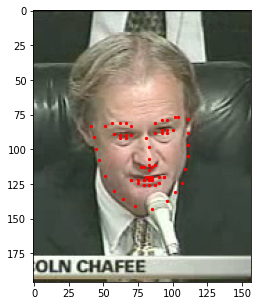

In [0]:
image_name = key_df.iloc[1,0]
image_path = 'data/training/' + image_name

image = mpimg.imread(image_path)
print(f'Shape of the image: {image.shape}')
keypoints = np.array(key_df.iloc[1,1:],dtype='float').reshape(-1,2)

plt.figure(figsize=(5,5))

display_keypoints(image,keypoints)
plt.show()

The Red dots represent the facial keypoints. This is what we are gonna train our model to identify for any image containing a face.

If we also take a closer look at the shape of the image, the third dimension of its shape has four values which means that the image is an RGBA(Red Green Blue Alpha) image where the alpha channel is the opacity of the image. We need to get rid of it while processing the data. 

#**3. Creating a custom Dataset and DataLoader using torch**

**1. Building a custom dataset class**

In [0]:
class KeypointsDataset(Dataset):

  def __init__(self,csv_file, root_dir, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.key_df = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.key_df)

  def __getitem__(self,idx):
    
    image_path = os.path.join(self.root_dir,self.key_df.iloc[idx,0])
    image = mpimg.imread(image_path)

    # Lets drop the alpha channel if any
    if image.shape[2] == 4:
      image = image[:,:,:3]

    # generate x-y pairs matrix of all the keypoints
    keypoints = np.array(self.key_df.iloc[idx,1:],dtype='float').reshape(-1,2)

    sample = {'image': image, 'keypoints': keypoints}

    # Apply transform if any
    if self.transform:
      sample = self.transform(sample)

    return sample

**2. Defining the Transforms**

Transforms are an essential part of data preprocessing as all the data has to be of the same form for the model to train.

Therefore, we will need to write some pre-processing code. Let's create four transforms:

* Normalize: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
* Rescale: to rescale an image to a desired size.
* RandomCrop: to crop an image randomly.
* ToTensor: to convert numpy images to torch images.

In [0]:
class Normalize(object):
  '''
  Converts a colored image to grayscale and then normalizes the color range 
  to [0,1]
  '''

  def __call__(self,sample):
    image, keypoints = sample['image'], sample['keypoints']

    image_copy = np.copy(image)
    keypoints_copy = np.copy(keypoints)

    # convert image to Gray-scale
    image_copy = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # scale color from [0,255] to [0,1]
    image_copy = image_copy / 255.0

    # scale keypoints to be centered around 0 with a range of [-1, 1]
    # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
    keypoints_copy = (keypoints_copy - 100)/50.0

    return {'image' : image_copy , 'keypoints' : keypoints_copy}


class Rescale(object):
  """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
        matched to output_size. If int, smaller of image edges is matched
        to output_size keeping aspect ratio the same.
    """
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size

  def __call__(self, sample):
    image, keypoints = sample['image'], sample['keypoints']

    h, w = image.shape[:2]
    if isinstance(self.output_size, int):
      if h > w:
          new_h, new_w = self.output_size * h / w, self.output_size
      else:
          new_h, new_w = self.output_size, self.output_size * w / h
    else:
        new_h, new_w = self.output_size

    new_h, new_w = int(new_h), int(new_w)

    img = cv2.resize(image, (new_w, new_h))
    
    # scale the pts, too
    keypoints = keypoints * [new_w / w, new_h / h]

    return {'image': img, 'keypoints': keypoints}


class RandomCrop(object):
  """Crop randomly the image in a sample.

  Args:
      output_size (tuple or int): Desired output size. If int, square crop
          is made.
  """

  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):
        self.output_size = (output_size, output_size)
    else:
        assert len(output_size) == 2
        self.output_size = output_size

  def __call__(self, sample):
    image, keypoints = sample['image'], sample['keypoints']

    h, w = image.shape[:2]
    new_h, new_w = self.output_size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top: top + new_h,
                  left: left + new_w]

    keypoints = keypoints - [left, top]

    return {'image': image, 'keypoints': keypoints}


class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""

  def __call__(self, sample):
    image, key_pts = sample['image'], sample['keypoints']
      
    # if image has no grayscale color channel, add one
    if(len(image.shape) == 2):
        # add that third color dim
        image = image.reshape(image.shape[0], image.shape[1], 1)
        
    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    image = image.transpose((2, 0, 1))
    
    return {'image': torch.from_numpy(image),
            'keypoints': torch.from_numpy(key_pts)}



**3. Testing the transform**

In [0]:
face_dataset = KeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                      root_dir='data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


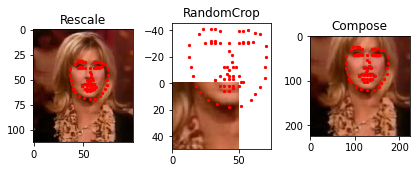

In [0]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 500
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    display_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

**4.Putting it all together**

In [0]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = KeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

In [0]:
# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    # print(sample['image'].shape)
    print(i, sample['image'].shape, sample['keypoints'].shape)

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


The Dataset is now ready and can be give to DataLoaders from where data would be extracted in batches

**5.Creating the DataLoaders**

In [0]:
# load training data in batches
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=32,
                          shuffle=True, 
                          num_workers=4)

**6. Load the Test Data**

In [0]:

# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = KeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)


# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

#**4. Model Building**

In [0]:
class Net(nn.Module):

  '''
  Define all the layers of this CNN, the only requirements are:
  1. This network takes in a square (same width and height), grayscale image as input
  2. It ends with a linear layer that represents the keypoints
  Last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
  '''

  def __init__(self):
    super().__init__()

    # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
    
    ## Shape of a Convolutional Layer
    # K - out_channels : the number of filters in the convolutional layer
    # F - kernel_size
    # S - the stride of the convolution
    # P - the padding
    # W - the width/height (square) of the previous layer
    
    # Since there are F*F*D weights per filter
    # The total number of weights in the convolutional layer is K*F*F*D
    
    # 224 by 224 pixels
    
    ## self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
    

    # output size = (W-F)/S +1 = (224-5)/1 +1 = 220
    # output tensor after conv1 (32, 220, 220,1)
    self.conv1 = nn.Conv2d(1,32,5)

    # maxpool layer
    # pool with kernel_size=2, stride=2
    self.pool = nn.MaxPool2d(2,2)

    # 220/2 = 110
    # after max pool1 : (32, 110, 110,1)
    # output size = (W-F)/S +1 = (110-3)/1 + 1 = 108
    # output tensor after conv2 (64, 108, 108,1)
    self.conv2 = nn.Conv2d(32,64,3)

    # After max pool from conv2 layer tensor shape = (64,54,54,1)
    # output size = (W-F)/S +1 = (54-3)/1 + 1 = 52
    # output tensor after conv3 (128, 52, 52,1)
    self.conv3 = nn.Conv2d(64,128,3)

    # After max pool from conv3 layer tensor shape = (128,26,26,1)
    # output size = (W-F)/S +1 = (26-3)/1 + 1 = 24
    # output tensor after conv4 (256, 24, 24,1)
    self.conv4 = nn.Conv2d(128, 256, 3)

    # After max pool from conv4 layer tensor shape = (256,12,12,1)
    # output size = (W-F)/S +1 = (12-3)/1 + 1 = 12
    # output tensor after conv1 (512, 12, 12,1)
    self.conv5 = nn.Conv2d(256, 512, 1)

    # After max pool from conv5 layer tensor shape = (512,6,6,1)
    # output size = (W-F)/S +1 = (6-1)/1 + 1 = 6
    # output tensor(512,6,6,1)

    # Fully-connected (linear) layers
    self.fc1 = nn.Linear(512*6*6, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 68*2)
    
    # Dropout
    self.dropout = nn.Dropout(p=0.25)

  def forward(self, x):
    ## Define the feedforward behavior of this model
    ## x is the input image and, as an example, here you may choose to include a pool/conv step:
    
    # 5 conv/relu + pool layers
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = self.pool(F.relu(self.conv5(x)))
    
    # Prep for linear layer / Flatten
    x = x.view(x.size(0), -1)
    
    # linear layers with dropout in between
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    
    return x


In [0]:
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=136, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

# **5. Testing on Untrained Model**

**1. Before training**

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.


**Apply the model on a test sample**

To test the model on a test sample of data, we have to follow these steps:

1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [0]:
def net_sample_output():

  # iterate through the test dataset
  for i, sample in enumerate(test_loader):

    # get the sample data: images and ground truth keypoints
    images = sample['image']
    keypoints = sample['keypoints']

    # convert images to FloatTensor
    images = images.type(torch.FloatTensor)
    images = images.to(device)

    # forward pass to get net output
    output = model(images)

    # reshape to batch_size x 68 x 2 points
    output = output.view(output.size(0), 68, -1)

    if i == 0 :
      return images, output, keypoints

In [0]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


**Visualize the results**

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

The new function, show_all_keypoints displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [0]:
def show_all_keypoints(image, predicted_keypoints,keypoints=None):
  '''show images with predicted and original keypoints'''

  # image is grayscale
  plt.imshow(image,cmap='gray')
  plt.scatter(predicted_keypoints[:,0],predicted_keypoints[:,1],s=20, marker='.', c='yellow')

  if keypoints is not None:
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='red')                                                    

**Reverse-transformation**

Next, you'll see a helper function. visualize_output that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The reverse-transformation process turns keypoints and images into numpy arrays from Tensors and it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

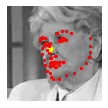

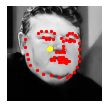

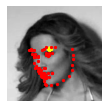

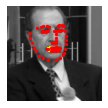

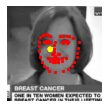

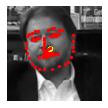

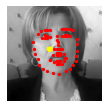

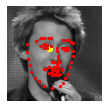

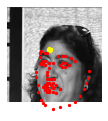

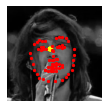

In [0]:
# visualize the output

def visualize_output(test_images, test_outputs, keypoints = None,batch_size=10):

  for i in range(batch_size):
    plt.figure(figsize = (20,10))
    ax = plt.subplot(1,batch_size, i + 1)

    ## reverse-transform the image
    
    # get the image from variable wrapper
    image = test_images[i].data
    # convert tensor to numpy
    image = image.detach().cpu().numpy()
    # transpose image from (channel,height,width) to (height,width,channel)
    image = np.transpose(image,(1,2,0))

    ## reverse-transform the keypoints

    # get the outputs from variable wrapper
    predicted_keypoints = test_outputs[i].data
    # tensor to numpy
    predicted_keypoints = predicted_keypoints.detach().cpu().numpy()
    # undo normalization of keypoints  
    predicted_keypoints = predicted_keypoints*50.0 + 100

    # plot true keypoints for comparison if any
    ground_truth_pts = None
    if keypoints is not None:
      ground_truth_pts = keypoints[i]         
      ground_truth_pts = ground_truth_pts*50.0 + 100

    # call show_all_keypoints
    show_all_keypoints(np.squeeze(image), predicted_keypoints, ground_truth_pts)
        
    plt.axis('off')

  plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

# **6. Training the Model**

**Loss function**

Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, we have to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss

In [0]:
## Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [0]:
from tqdm import tqdm
# train function

def train_net(n_epochs):

  # set model to train model
  model.train()

  training_loss = []

  for e in tqdm(range(n_epochs)):

    running_loss = 0

    # iterate through the batches
    for ii, data in enumerate(train_loader):

      # get image and keypoints
      images = data['image']
      keypoints = data['keypoints']

      # flatten the keypoints
      keypoints = keypoints.view(keypoints.size(0),-1)

      # convert variables to float for regression loss
      images = images.type(torch.FloatTensor)
      keypoints = keypoints.type(torch.FloatTensor)
      images, keypoints = images.to(device), keypoints.to(device)

      # forward pass
      output_pts = model(images)

      # calc the loss
      loss = criterion(output_pts,keypoints)

      # avoid gradient accumalation
      optimizer.zero_grad()

      # backward propogation
      loss.backward()

      # update weights
      optimizer.step()

      # print loss statistics
      running_loss += loss.item()

      # print loss
      if ii % 10 == 9:
        print(f'Epoch: {e+1}, Batch : {ii+1}, Avg Loss : {running_loss/10}')
        running_loss = 0

    training_loss.append(running_loss)

  return training_loss

In [0]:
# train your network
n_epochs = 10

training_loss = train_net(n_epochs)



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, Batch : 10, Avg Loss : 0.26275276094675065
Epoch: 1, Batch : 20, Avg Loss : 0.18810950964689255
Epoch: 1, Batch : 30, Avg Loss : 0.1700550749897957
Epoch: 1, Batch : 40, Avg Loss : 0.16869678273797034
Epoch: 1, Batch : 50, Avg Loss : 0.1670789062976837
Epoch: 1, Batch : 60, Avg Loss : 0.14637602865695953
Epoch: 1, Batch : 70, Avg Loss : 0.18557790368795396
Epoch: 1, Batch : 80, Avg Loss : 0.1471508927643299
Epoch: 1, Batch : 90, Avg Loss : 0.14916597157716752
Epoch: 1, Batch : 100, Avg Loss : 0.1488619141280651




 10%|█         | 1/10 [00:20<03:05, 20.58s/it]

Epoch: 2, Batch : 10, Avg Loss : 0.13944156393408774
Epoch: 2, Batch : 20, Avg Loss : 0.15029897913336754
Epoch: 2, Batch : 30, Avg Loss : 0.17663182243704795
Epoch: 2, Batch : 40, Avg Loss : 0.20260268747806548
Epoch: 2, Batch : 50, Avg Loss : 0.18245616778731347
Epoch: 2, Batch : 60, Avg Loss : 0.21337183713912963
Epoch: 2, Batch : 70, Avg Loss : 0.15628818273544312
Epoch: 2, Batch : 80, Avg Loss : 0.15747700855135918
Epoch: 2, Batch : 90, Avg Loss : 0.13101116046309472
Epoch: 2, Batch : 100, Avg Loss : 0.13894584774971008




 20%|██        | 2/10 [00:40<02:43, 20.47s/it]

Epoch: 3, Batch : 10, Avg Loss : 0.1595347672700882
Epoch: 3, Batch : 20, Avg Loss : 0.167896169424057
Epoch: 3, Batch : 30, Avg Loss : 0.14664816707372666
Epoch: 3, Batch : 40, Avg Loss : 0.13768168911337852
Epoch: 3, Batch : 50, Avg Loss : 0.12296567335724831
Epoch: 3, Batch : 60, Avg Loss : 0.16227525174617768
Epoch: 3, Batch : 70, Avg Loss : 0.12606969773769378
Epoch: 3, Batch : 80, Avg Loss : 0.11943084523081779
Epoch: 3, Batch : 90, Avg Loss : 0.10807413309812545
Epoch: 3, Batch : 100, Avg Loss : 0.10737485885620117




 30%|███       | 3/10 [01:00<02:22, 20.37s/it]

Epoch: 4, Batch : 10, Avg Loss : 0.09503658413887024
Epoch: 4, Batch : 20, Avg Loss : 0.087104157730937
Epoch: 4, Batch : 30, Avg Loss : 0.10332265049219132
Epoch: 4, Batch : 40, Avg Loss : 0.09509623907506466
Epoch: 4, Batch : 50, Avg Loss : 0.10835540294647217
Epoch: 4, Batch : 60, Avg Loss : 0.099622106179595
Epoch: 4, Batch : 70, Avg Loss : 0.10910753086209297
Epoch: 4, Batch : 80, Avg Loss : 0.07905648685991765
Epoch: 4, Batch : 90, Avg Loss : 0.08895455785095692
Epoch: 4, Batch : 100, Avg Loss : 0.06241212375462055




 40%|████      | 4/10 [01:21<02:01, 20.30s/it]

Epoch: 5, Batch : 10, Avg Loss : 0.08999445848166943
Epoch: 5, Batch : 20, Avg Loss : 0.06260040886700154
Epoch: 5, Batch : 30, Avg Loss : 0.06281019486486912
Epoch: 5, Batch : 40, Avg Loss : 0.07702425792813301
Epoch: 5, Batch : 50, Avg Loss : 0.07563005574047565
Epoch: 5, Batch : 60, Avg Loss : 0.07634900212287903
Epoch: 5, Batch : 70, Avg Loss : 0.053594356030225755
Epoch: 5, Batch : 80, Avg Loss : 0.08282456658780575
Epoch: 5, Batch : 90, Avg Loss : 0.06598415300250053
Epoch: 5, Batch : 100, Avg Loss : 0.061218484118580815




 50%|█████     | 5/10 [01:41<01:41, 20.21s/it]

Epoch: 6, Batch : 10, Avg Loss : 0.059648430347442626
Epoch: 6, Batch : 20, Avg Loss : 0.06503143534064293
Epoch: 6, Batch : 30, Avg Loss : 0.059809642285108565
Epoch: 6, Batch : 40, Avg Loss : 0.09460273124277592
Epoch: 6, Batch : 50, Avg Loss : 0.10224525257945061
Epoch: 6, Batch : 60, Avg Loss : 0.061688128486275674
Epoch: 6, Batch : 70, Avg Loss : 0.05495759528130293
Epoch: 6, Batch : 80, Avg Loss : 0.05863541290163994
Epoch: 6, Batch : 90, Avg Loss : 0.04949072115123272
Epoch: 6, Batch : 100, Avg Loss : 0.05524092577397823




 60%|██████    | 6/10 [02:01<01:20, 20.18s/it]

Epoch: 7, Batch : 10, Avg Loss : 0.061020738631486895
Epoch: 7, Batch : 20, Avg Loss : 0.04804728254675865
Epoch: 7, Batch : 30, Avg Loss : 0.04760392941534519
Epoch: 7, Batch : 40, Avg Loss : 0.05384375024586916
Epoch: 7, Batch : 50, Avg Loss : 0.050896552950143815
Epoch: 7, Batch : 60, Avg Loss : 0.1055107668042183
Epoch: 7, Batch : 70, Avg Loss : 0.045591102167963984
Epoch: 7, Batch : 80, Avg Loss : 0.04929539635777473
Epoch: 7, Batch : 90, Avg Loss : 0.0462228624150157
Epoch: 7, Batch : 100, Avg Loss : 0.05970562696456909




 70%|███████   | 7/10 [02:21<01:00, 20.09s/it]

Epoch: 8, Batch : 10, Avg Loss : 0.04395537078380585
Epoch: 8, Batch : 20, Avg Loss : 0.04249427001923323
Epoch: 8, Batch : 30, Avg Loss : 0.04621679317206144
Epoch: 8, Batch : 40, Avg Loss : 0.070628722012043
Epoch: 8, Batch : 50, Avg Loss : 0.06321354415267706
Epoch: 8, Batch : 60, Avg Loss : 0.0416901495307684
Epoch: 8, Batch : 70, Avg Loss : 0.04607076868414879
Epoch: 8, Batch : 80, Avg Loss : 0.05027627646923065
Epoch: 8, Batch : 90, Avg Loss : 0.05970519818365574
Epoch: 8, Batch : 100, Avg Loss : 0.03671129252761603




 80%|████████  | 8/10 [02:40<00:39, 19.99s/it]

Epoch: 9, Batch : 10, Avg Loss : 0.05713863372802734
Epoch: 9, Batch : 20, Avg Loss : 0.03491516578942537
Epoch: 9, Batch : 30, Avg Loss : 0.042808452434837815
Epoch: 9, Batch : 40, Avg Loss : 0.04721462614834308
Epoch: 9, Batch : 50, Avg Loss : 0.03263972103595734
Epoch: 9, Batch : 60, Avg Loss : 0.05996368043124676
Epoch: 9, Batch : 70, Avg Loss : 0.05198327638208866
Epoch: 9, Batch : 80, Avg Loss : 0.039962544851005075
Epoch: 9, Batch : 90, Avg Loss : 0.03503086436539889
Epoch: 9, Batch : 100, Avg Loss : 0.037157180905342105




 90%|█████████ | 9/10 [03:00<00:19, 19.98s/it]

Epoch: 10, Batch : 10, Avg Loss : 0.043851487897336484
Epoch: 10, Batch : 20, Avg Loss : 0.03776399437338114
Epoch: 10, Batch : 30, Avg Loss : 0.04444820042699575
Epoch: 10, Batch : 40, Avg Loss : 0.04370386376976967
Epoch: 10, Batch : 50, Avg Loss : 0.039213663712143895
Epoch: 10, Batch : 60, Avg Loss : 0.04151938837021589
Epoch: 10, Batch : 70, Avg Loss : 0.03606647588312626
Epoch: 10, Batch : 80, Avg Loss : 0.029409529641270638
Epoch: 10, Batch : 90, Avg Loss : 0.0438610726967454
Epoch: 10, Batch : 100, Avg Loss : 0.03359135054051876




100%|██████████| 10/10 [03:20<00:00, 20.04s/it]


In [0]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        y = training_loss,
        mode = 'lines',
        name = 'loss',
    )
)
fig.update_layout(
    title = 'Training Loss',
    xaxis = {
        'title' : 'Number of epochs'
    }
)
fig.show()

**Save the Model**

In [0]:
checkpoints = {
    'epochs': n_epochs,
    'alpha' : 0.001,
    'state_dict' : model.state_dict(),
    'loss' : training_loss[-1],
    'optimizer_state_dict': optimizer.state_dict()
}
torch.save(checkpoints, 'model.pth')

#**7. Testing the Model**

In [0]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


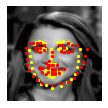

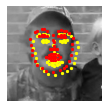

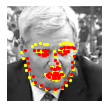

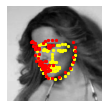

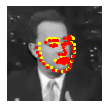

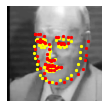

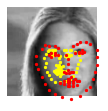

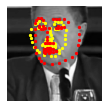

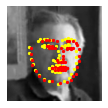

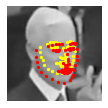

In [0]:
## visualize  test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)